# Kalman and Bayesian Filter in python

## Chapter 1 gh filter workbook

https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/01-g-h-filter.ipynb

In [1]:
import numpy as np
import pandas as pd
import altair as alt

weights = [158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 
           169.6, 167.4, 166.4, 171.0, 171.2, 172.6]

In [2]:
time_step = 1.0  # day
scale_factor = 4.0 / 10.0

In [3]:
def predict_using_gain_guess(estimated_weight, z, gain_rate):
    predicted_weight = estimated_weight + gain_rate * time_step
    estimated_weight = predicted_weight + scale_factor * (z - predicted_weight)
    return estimated_weight, predicted_weight

estimated_weight = 160.0  # init guess
df = pd.DataFrame({'estimated': [estimated_weight], 'z': [np.nan], 'predicted': [np.nan]})
for z in weights:
    estimated_weight, predicted_weight  = predict_using_gain_guess(
        estimated_weight, z, gain_rate = 1.0)
    df = pd.concat([df, pd.DataFrame(
        [[estimated_weight, z, predicted_weight]],
        columns=['estimated', 'z', 'predicted']
    )], ignore_index=True)

df = df.reset_index().rename(columns={'index': 'step'})
df.head()

,step,estimated,z,predicted
0,0,160.0000,NaN,NaN
1,1,159.8000,158.0,161.000
2,2,162.1600,164.2,160.800
3,3,162.0160,160.3,163.160
4,4,161.7696,159.9,163.016


In [4]:
df = pd.melt(df, id_vars='step')
df.head()

,step,variable,value
0,0,estimated,160.0000
1,1,estimated,159.8000
2,2,estimated,162.1600
3,3,estimated,162.0160
4,4,estimated,161.7696


In [5]:
alt.Chart(df).mark_line().encode(
    x='step',
    y=alt.Y('value', scale=alt.Scale(zero=False)),
    color='variable',
    shape=alt.Shape('variable')
)  #.interactive()
# does not render this chart in the github

alt.Chart(...)

## Chapter 2 Discrete Bayes Filter workbook

https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/02-Discrete-Bayes.ipynb

### Tracking a dog

* H: Hallway에서 dog의 위치
* D: door event
* S: Sensor emits door signal event

D에 대한 확실한 정보가 있다면, 알고자 하는 사항 $P(H|D)$은 다음과 같다.

* $P(H|D) \propto P(H) \times P(D|H)$

In [19]:
%matplotlib inline
from collections import deque
# from functools import reduce
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt

from filterpy.discrete_bayes import normalize

In [4]:
P_D_given_H = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])
P_H = np.array([0.1] * 10)

In [6]:
P_H_given_D = P_H * P_D_given_H
P_H_given_D = normalize(P_H_given_D)

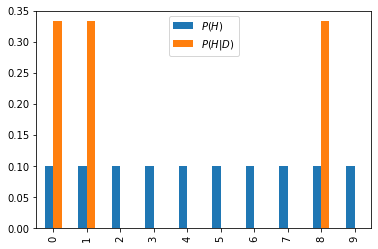

In [11]:
df = pd.DataFrame({
    'P_H': P_H,
    'P_H_given_D': P_H_given_D
})
fig, ax = plt.subplots()
df.plot(kind='bar', ax=ax)
ax.legend(['$P(H)$', '$P(H|D)$'])

#### Noisy sensors

sensor S를 통하여 D에 대한 정보를 얻을 때, 알고자 하는 사항 $P(H|S)$은 다음과 같다.

* $P(H|S) \propto P(H) \times P(S|H)$

그런데, $H=h \in \{0, 1, \cdots 9\}$에서 D는 고정되어 $P(D|H) = 1$이거나 $P(D^c|H) = 1$이 된다.

\begin{align}
P(S|H) &= P(S,D|H) + P(S,D^c|H) \\
&= P(D|H)P(S|D,H) \: \text{or} \: P(D^c|H)P(S|D^c,H) \\
&= 1 \times 3/4  \: \text{for} \: P(D|H) = 1 \: \text{else} \: 1/4
\end{align}

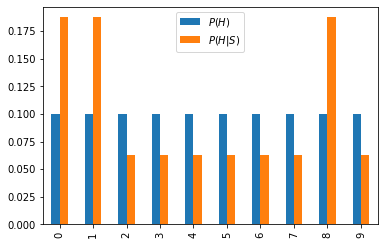

In [23]:
P_D_given_H = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])
P_S_given_H = np.array([3/4 if d else 1/4 for d in P_D_given_H])
P_H_given_S = P_H * P_S_given_H
P_H_given_S = normalize(P_H_given_S)
df = pd.DataFrame({
    'P_H': P_H,
    'P_H_given_S': P_H_given_S
})
fig, ax = plt.subplots()
df.plot(kind='bar', ax=ax)
ax.legend(['$P(H)$', '$P(H|S)$'])

#### Incorporating movement

\begin{align}
P(H_t = k_t | M = m) &= \sum_{k_{t-1}} P(H_t = k_t, H_{t-1} = k_{t-1} | M = m) \\
&= \sum_{k_{t-1}} P( H_{t-1} = k_{t-1} | M = m) P(H_t = k_t | H_{t-1} = k_{t-1},  M = m) \\
&= \sum_{k_{t-1}} P( H_{t-1} = k_{t-1} ) P(H_t = k_t | H_{t-1} = k_{t-1},  M = m)
\end{align}

where,

\begin{equation}
P(H_t = k_t | H_{t-1} = k_{t-1},  M = m) = \left\{ \begin{array}{ll}
0.1 & \text{for} \: k_{t} - k_{t-1} - m = -1 \\
0.8 & \text{for} \: k_{t} - k_{t-1} - m = 0 \\
0.1 & \text{for} \: k_{t} - k_{t-1} - m = +1 \\
0 & \text{elsewhere}
\end{array} \right.
\end{equation}


In [84]:
def likelihood(k_t, k_t_1, m, prob):
    # prob = dict([(-1, 0.1), (0, 0.8), (1, 0.1)])
    k = k_t - k_t_1 - m
    k = k if k in prob.keys() else k % 10
    return prob[k] if k in prob.keys() else 0

def posterior(k_t, m, H_t_1, prob):
    return sum([prior_k * likelihood(k_t, k, m, prob) for k, prior_k in enumerate(H_t_1)])

In [85]:
prob = dict([(-1, 0), (0, 1.0), (1, 0)])
H_t_1 = np.array([.35, .1, .2, .3, 0, 0, 0, 0, 0, .05])
H = map(lambda k_t: posterior(k_t, 1, H_t_1, prob), range(len(H_t_1)))

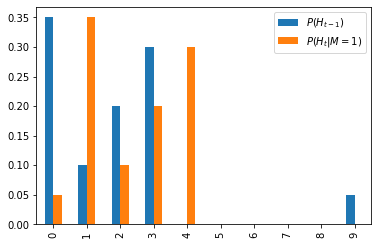

In [86]:
df = pd.DataFrame({
    'P_H_t_1': H_t_1,
    'P_H_M': H
})
fig, ax = plt.subplots()
df.plot(kind='bar', ax=ax)
ax.legend(['$P(H_{t-1})$', '$P(H_t|M=1)$'])

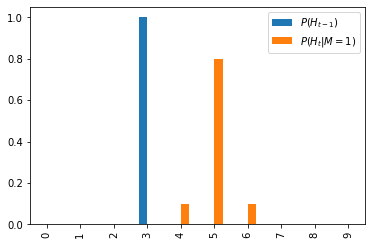

In [87]:
prob = dict([(-1, 0.1), (0, 0.8), (1, 0.1)])
H_t_1 = np.array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
H = map(lambda k_t: posterior(k_t, 2, H_t_1, prob), range(len(H_t_1)))
df = pd.DataFrame({
    'P_H_t_1': H_t_1,
    'P_H_M': H
})
fig, ax = plt.subplots()
df.plot(kind='bar', ax=ax)
ax.legend(['$P(H_{t-1})$', '$P(H_t|M=1)$'])

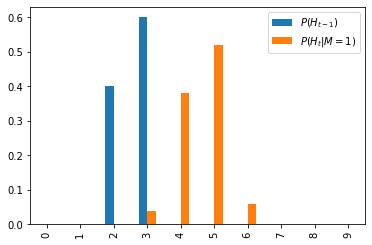

In [88]:
prob = dict([(-1, 0.1), (0, 0.8), (1, 0.1)])
H_t_1 = np.array([0, 0, .4, .6, 0, 0, 0, 0, 0, 0])
H = map(lambda k_t: posterior(k_t, 2, H_t_1, prob), range(len(H_t_1)))
df = pd.DataFrame({
    'P_H_t_1': H_t_1,
    'P_H_M': H
})
fig, ax = plt.subplots()
df.plot(kind='bar', ax=ax)
ax.legend(['$P(H_{t-1})$', '$P(H_t|M=1)$'])

[0.104, 0.103, 0.101, 0.099, 0.097, 0.096, 0.097, 0.099, 0.101, 0.103]


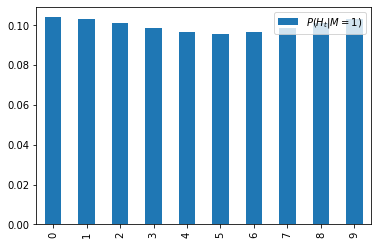

In [99]:
prob = dict([(-1, 0.1), (0, 0.8), (1, 0.1)])
H_t_1 = np.array([1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
for _ in range(100):
    H_t_1 = list(map(lambda k_t: posterior(k_t, 1, H_t_1, prob), range(10)))


print([float(f'{el:.3f}') for el in H_t_1])
df = pd.DataFrame({
    'P_H_M': H_t_1
})
fig, ax = plt.subplots()
df.plot(kind='bar', ax=ax)
ax.legend(['$P(H_t|M=1)$'])

## Generalizing with convolution

### numpy convolve

\begin{equation}
(a \ast v) [n] = \sum_{m=-\infty}^{\infty} a[m] v[n-m]
\end{equation}

In [3]:
import numpy as np
import pandas as pd
from scipy import signal

a = [.05, .05, .05, .05, .55, .05, .05, .05, .05, .05]
b = [0.1, 0.8, 0.1]

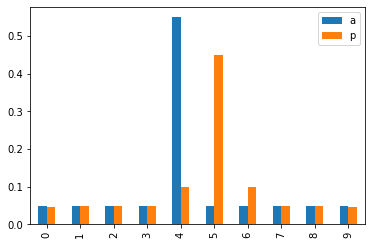

In [6]:
p = np.convolve(np.roll(a, 1), b, 'same')

pd.DataFrame({'a': a, 'p': p}).plot(kind='bar')

위의 방법은 경계 부근에서 circular 다음과 같이 결과를 얻을 수 없다.

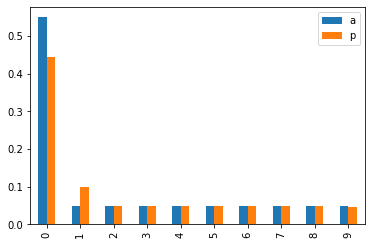

In [8]:
a = [.55, .05, .05, .05, .05, .05, .05, .05, .05, .05]
b = [0.1, 0.8, 0.1]

p = np.convolve(np.roll(a, 0), b, 'same')

pd.DataFrame({'a': a, 'p': p}).plot(kind='bar')

fft를 이용하여 우리가 원하는 결과를 얻을 수 있다.

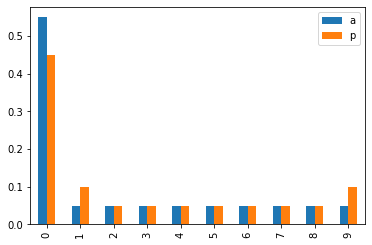

In [27]:
from scipy import fft

a = np.array([.55, .05, .05, .05, .05, .05, .05, .05, .05, .05])
b = np.array([0.1, 0.8, 0.1] + [0.0] * 7)

b = np.roll(b, -1)  # set kernel center index to 0

# b = np.roll(b, 2)

ta = fft.fft(a)
tb = fft.fft(b)
tp = ta * tb
p = fft.ifft(tp)
p = np.real(p)

pd.DataFrame({'a': a, 'p': p}).plot(kind='bar')

filterpy package로 다음과 같이 위의 결과를 얻을 수 있다.

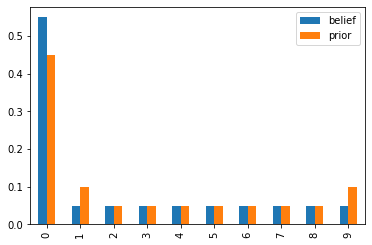

In [26]:
from filterpy.discrete_bayes import predict

belief = a
prior = predict(belief, offset=0, kernel=[0.1, 0.8, 0.1])
pd.DataFrame({'belief': belief, 'prior': prior}).plot(kind='bar')

## Integrating Mesurements and movement updates

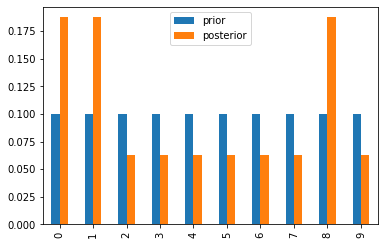

In [1]:
import numpy as np
import pandas as pd
from filterpy.discrete_bayes import update, predict

def lh_hallway(hall, z, z_prob):
    """ compute likelihood that a measurement matches
    positions in the hallway."""
    
    try:
        scale = z_prob / (1. - z_prob)
    except ZeroDivisionError:
        scale = 1e8

    likelihood = np.ones(len(hall))
    likelihood[hall==z] *= scale
    return likelihood


hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])
prior = np.array([.1] * 10)
likelihood = lh_hallway(hallway, z=1, z_prob=.75)
posterior = update(likelihood, prior)
pd.DataFrame({'prior': prior, 'posterior': posterior}).plot(kind='bar')

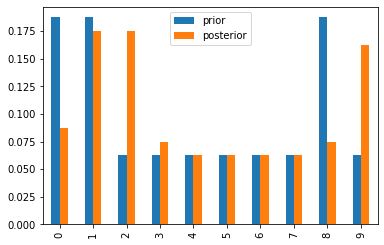

In [2]:
kernel = (0.1, 0.8, 0.1)
prior = posterior.copy()
posterior = predict(posterior, 1, kernel)
pd.DataFrame({'prior': prior, 'posterior': posterior}).plot(kind='bar')

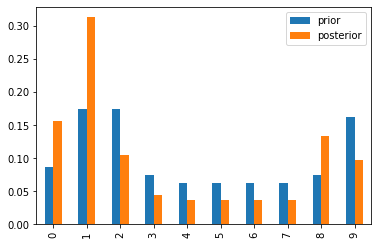

In [3]:
prior = posterior.copy()
likelihood = lh_hallway(hallway, z=1, z_prob=.75)
posterior = update(likelihood, prior)
pd.DataFrame({'prior': prior, 'posterior': posterior}).plot(kind='bar')

## The Discrete Bayes Algorithm

\begin{align}
\bar x &= x \ast f_x & \text{Predict step} \\
x &= || \mathcal{L} \cdot \bar x || & \text{Update step}
\end{align}

* Predict: Based on the system behavior, predict state for the next time step
* Update: Get a measurment and compute likelihood, and update state

## Product of Gaussians

[Conditional bivariate normal distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions)

\begin{align}
p(x|z) &\propto p(x, z) \\
&= \exp \left[ - \frac{1}{2} \begin{pmatrix} x - \mu_x \\ z - \mu_z \end{pmatrix}^T \Sigma^{-1} \begin{pmatrix} x - \mu_x \\ z - \mu_z \end{pmatrix}  \right]
\end{align}

단, $\Sigma = \begin{pmatrix} \sigma_{xx} & \sigma_{xz} \\ \sigma_{xz} & \sigma_{zz} \end{pmatrix}$이다. 다음 식을 풀어 위 식에 대입하면,

\begin{align}
\begin{pmatrix} x \\ z \end{pmatrix} &= \begin{pmatrix} \sigma_{xx} & \sigma_{xz} \\ \sigma_{xz} & \sigma_{zz} \end{pmatrix} \begin{pmatrix} a \\ b \end{pmatrix}
\end{align}

\begin{align}
p(x|z) &\propto \exp \left[ -\frac{1}{2(\sigma_{xx} \sigma_{zz} - \sigma_{xz}^2)} \begin{pmatrix} x - \mu_x \\ z - \mu_z \end{pmatrix}^T \begin{pmatrix} \sigma_{zz} & -\sigma_{xz} \\ -\sigma_{xz} & \sigma_{xx} \end{pmatrix} \begin{pmatrix} x - \mu_x \\ z - \mu_z \end{pmatrix} \right] \\
&= \exp \left[ -\frac{\sigma_{zz} (x - \mu_x - \sigma_{xz} / \sigma_{zz} (z - \mu_z))^2 \cdots}{2(\sigma_{xx} \sigma_{zz} - \sigma_{xz}^2)} \right]
\end{align}

조건부 확률의 기대치와 분산은,

\begin{align}
E(X|Z=z) &= \mu_x + \frac{\sigma_{xz} }{\sigma_{zz}} (z - \mu_z) \\
var(X|Z=z) &= \sigma_{xx} - \frac{\sigma_{xz}^2}{\sigma_{zz}}
\end{align}

Bayesian posterior distribution

prior $x \sim N(\bar \mu, \bar \sigma^2)$, likelihood for the mesurement z, $z \sim N(x, \sigma_z^2)$

\begin{align}
p(x|z) &\propto p(x) p(z|x) \\
&\propto \exp \left[ -\frac{(x-\bar \mu)^2}{2 \bar \sigma^2} \right] \left[ -\frac{(z-x)^2}{2 \sigma_z^2} \right] \\
&\propto \exp \left[ -\frac{1}{2} \frac{x - \frac{\sigma_z^2 \bar \mu + \bar \sigma^2 z}{\sigma_z^2 \bar + \bar \sigma^2}}{\frac{\sigma_z^2 \bar \sigma^2}{\sigma_z^2 \bar + \bar \sigma^2}} \right]
\end{align}

조건부 확률의 기대치와 분산은,

\begin{align}
E(X|Z=z) &= \frac{\sigma_z^2 \bar \mu + \bar \sigma^2 z}{\sigma_z^2 \bar + \bar \sigma^2} \\
var(X|Z=z) &= \frac{\sigma_z^2 \bar \sigma^2}{\sigma_z^2 \bar + \bar \sigma^2}
\end{align}